# Fitbit Data Analysis 🏃‍♂️📊
# STEPS

## 📦 Imports

In [101]:
import json
import gzip
import pandas as pd
from datetime import datetime, timedelta
import boto3
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import lru_cache

#### =============================================================================

## 📥 Data Import Functions

In [102]:
# ============================================================================
# Helper Functions
# ============================================================================

def get_s3_client(profile='surface'):
    """
    Create a reusable S3 client with caching.
    
    Args:
        profile: AWS profile name (default: 'surface')
    
    Returns:
        boto3.client: Configured S3 client
    """
    session = boto3.Session(profile_name=profile)
    return session.client('s3')


def convert_to_local_tz(df, tz='Europe/London'):
    """
    Convert dataframe time column to specified timezone.
    
    Args:
        df: DataFrame with 'time' column in UTC
        tz: Target timezone (default: 'Europe/London')
    
    Returns:
        DataFrame: Copy with converted timezone
    
    Raises:
        ValueError: If 'time' column is missing or not timezone-aware
    """
    if df.empty:
        return df
    
    if 'time' not in df.columns:
        raise ValueError("DataFrame must contain 'time' column")
    
    if df['time'].dt.tz is None:
        raise ValueError("'time' column must be timezone-aware")
    
    df_copy = df.copy()
    df_copy['time'] = df_copy['time'].dt.tz_convert(tz)
    return df_copy


def validate_dataframe(df, required_columns, df_name='DataFrame'):
    """
    Validate that DataFrame is not empty and contains required columns.
    
    Args:
        df: DataFrame to validate
        required_columns: List of required column names
        df_name: Name of DataFrame for error messages
    
    Raises:
        ValueError: If validation fails
    """
    if df is None or df.empty:
        raise ValueError(f"{df_name} cannot be None or empty")
    
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"{df_name} missing required columns: {missing_cols}")

In [70]:
def parse_fitbit_data(data):
    """
    Parse the list of measurements into separate DataFrames by measurement type.
    
    Args:
        data: List of measurement records from Fitbit
    
    Returns:
        dict: Dictionary mapping measurement names to DataFrames
    
    Raises:
        ValueError: If data is empty or invalid
    """
    if not data:
        raise ValueError("Data cannot be empty")
    
    # Group data by measurement type using defaultdict for efficiency
    from collections import defaultdict
    measurements_dict = defaultdict(list)
    
    for record in data:
        if 'measurement' not in record:
            continue  # Skip malformed records
        measurements_dict[record['measurement']].append(record)
    
    # Convert each measurement type to a DataFrame
    dfs = {}
    
    for measurement, records in measurements_dict.items():
        parsed_records = []
        for record in records:
            flat_record = {'time': pd.to_datetime(record['time'])}
            
            # Add all tags
            if 'tags' in record:
                flat_record.update(record['tags'])
            
            # Add all fields
            if 'fields' in record:
                flat_record.update(record['fields'])
            
            parsed_records.append(flat_record)
        
        # Create DataFrame and sort by time
        df = pd.DataFrame(parsed_records).sort_values('time').reset_index(drop=True)
        dfs[measurement] = df
    
    return dfs

In [71]:
def get_fitbit_data_for_date(date_str, bucket_name='followcrom', profile='surface'):
    """
    Fetch Fitbit data for a specific date from S3.
    
    Args:
        date_str: Date in format 'YYYY-MM-DD'
        bucket_name: S3 bucket name (default: 'followcrom')
        profile: AWS profile name (default: 'surface')
    
    Returns:
        dict: Dictionary of DataFrames by measurement type, or None if not found
    
    Raises:
        ValueError: If date format is invalid or date is in the future
    """
    # Parse and validate date
    try:
        date = datetime.strptime(date_str, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Date must be in format 'YYYY-MM-DD'")
    
    # Check if date is not in the future
    if date.date() > datetime.now().date():
        raise ValueError(f"Date {date_str} is in the future. Cannot fetch future data.")
    
    # Build the file key
    file_key = f"cromwell/fitbit/fitbit_backup_{date.strftime('%Y-%m-%d')}.json.gz"
    
    print(f"📥 Fetching data for {date.strftime('%Y-%m-%d')} from S3...")
    print(f"   Bucket: {bucket_name}")
    print(f"   File: {file_key}")
    
    # Use cached S3 client
    s3 = get_s3_client(profile)
    
    try:
        response = s3.get_object(Bucket=bucket_name, Key=file_key)
        
        # Read and decompress data
        with gzip.GzipFile(fileobj=BytesIO(response['Body'].read())) as f:
            data = json.load(f)
        
        if not data:
            print(f"⚠️  File exists but contains no data")
            return None
        
        print(f"✅ Loaded {len(data):,} records")
        
        # Parse all data
        dfs = parse_fitbit_data(data)
        
        print(f"📊 Found {len(dfs)} measurement types:")
        for measurement, df in sorted(dfs.items()):
            print(f"   - {measurement}: {len(df):,} records")
        
        return dfs
        
    except s3.exceptions.NoSuchKey:
        print(f"❌ No data found for {date.strftime('%Y-%m-%d')}")
        print(f"   File not found: {file_key}")
        return None
    
    except json.JSONDecodeError as e:
        print(f"❌ Error parsing JSON data: {e}")
        return None
    
    except Exception as e:
        print(f"❌ Unexpected error fetching data: {type(e).__name__}: {e}")
        return None

In [72]:
date_input = input("Enter date (YYYY-MM-DD): ")
dfs = get_fitbit_data_for_date(date_input)

Enter date (YYYY-MM-DD):  2025-10-29


📥 Fetching data for 2025-10-29 from S3...
   Bucket: followcrom
   File: cromwell/fitbit/fitbit_backup_2025-10-29.json.gz
✅ Loaded 41,264 records
📊 Found 19 measurement types:
   - Activity-calories: 1 records
   - Activity-distance: 1 records
   - Activity-minutesFairlyActive: 1 records
   - Activity-minutesLightlyActive: 1 records
   - Activity-minutesSedentary: 1 records
   - Activity-minutesVeryActive: 1 records
   - Activity-steps: 1 records
   - ActivityRecords: 4 records
   - BreathingRate: 1 records
   - DeviceBatteryLevel: 1 records
   - HRV: 1 records
   - HR_Zones: 1 records
   - HeartRate_Intraday: 39,783 records
   - RestingHR: 1 records
   - SPO2_Daily: 1 records
   - SkinTemperature: 1 records
   - SleepLevels: 22 records
   - SleepSummary: 1 records
   - Steps_Intraday: 1,440 records


In [73]:
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())
df_activity_steps = dfs.get('Activity-steps', pd.DataFrame())
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())

print(f"✅ Found {len(df_steps_intra)} Steps records")
print(f"✅ Found {len(df_activity_steps)} Activity-steps records")
print(f"✅ Found {len(df_hr_intra)} HeartRate_Intraday records")

✅ Found 1440 Steps records
✅ Found 1 Activity-steps records
✅ Found 39783 HeartRate_Intraday records


In [81]:
# Extract date from the data for the titles
date_str = df_steps_intra['time'].iloc[0].strftime('%Y-%m-%d')
date_obj = datetime.strptime(date_str, '%Y-%m-%d')  # adjust format if needed
# Then format it
formatted_date = date_obj.strftime('%A, %dth %B')

In [76]:
print("Steps Timezone:", df_steps_intra['time'].dt.tz)
print("Activity-steps Timezone:", df_activity_steps['time'].dt.tz)

Steps Timezone: UTC
Activity-steps Timezone: UTC


In [77]:
print(df_activity_steps[['time', 'Device', 'value']].to_string())

                       time       Device   value
0 2025-10-29 12:00:00+00:00  PixelWatch3  9545.0


In [84]:
# ============================================================================
# OPTION 1: Steps vs Heart Rate Correlation
# ============================================================================

# Constants for consistent styling
COLOR_HR = '#ff4444'
COLOR_STEPS = '#4a90e2'
BAR_WIDTH_TIMEDELTA = 1 / 1440  # 1 minute in days for bar width

def plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra, tz='Europe/London'):
    """
    Plot steps and heart rate on dual y-axes to show correlation.
    
    Args:
        df_hr_intra: Intraday heart rate DataFrame
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display (default: 'Europe/London')
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    
    Raises:
        ValueError: If input DataFrames are invalid
    """
    # Validate inputs
    validate_dataframe(df_hr_intra, ['time', 'value'], 'Heart rate DataFrame')
    validate_dataframe(df_steps_intra, ['time', 'value'], 'Steps DataFrame')
    
    # Convert to local timezone
    df_hr = convert_to_local_tz(df_hr_intra, tz)
    df_steps = convert_to_local_tz(df_steps_intra, tz)
    
    # Extract date for the title
    date_str = df_hr['time'].iloc[0].strftime('%Y-%m-%d')
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot heart rate on primary y-axis
    ax1.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color=COLOR_HR)
    ax1.plot(df_hr['time'], df_hr['value'], color=COLOR_HR, linewidth=1.5, 
             label='Heart Rate', alpha=0.8)
    ax1.tick_params(axis='y', labelcolor=COLOR_HR)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Create secondary y-axis for steps
    ax2 = ax1.twinx()
    ax2.set_ylabel('Steps per Minute', fontsize=12, fontweight='bold', color=COLOR_STEPS)
    
    # Plot steps as bars
    ax2.bar(df_steps['time'], df_steps['value'], width=BAR_WIDTH_TIMEDELTA, 
            color=COLOR_STEPS, alpha=0.6, label='Steps/min')
    ax2.tick_params(axis='y', labelcolor=COLOR_STEPS)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Title with date
    plt.title(f"Steps vs Heart Rate Throughout the Day - {formatted_date}",
              fontsize=14, fontweight='bold', pad=20)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig

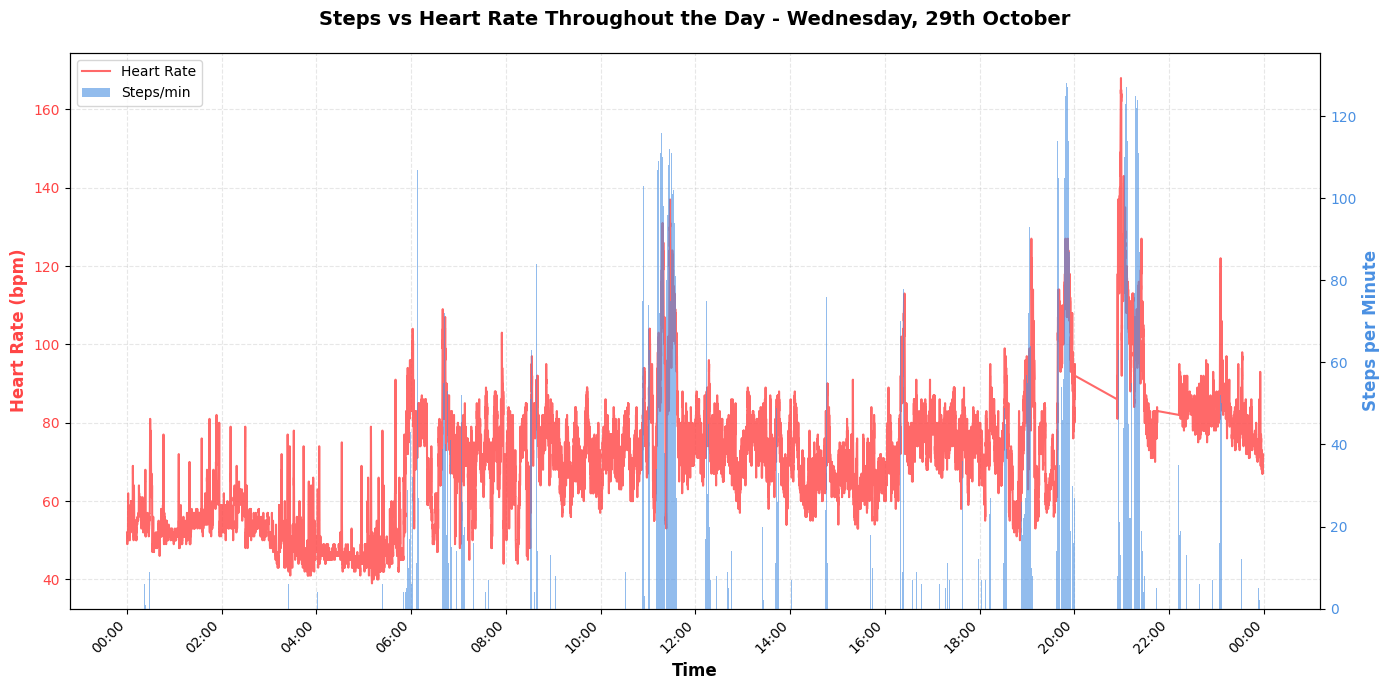

In [85]:
fig1 = plot_steps_vs_heart_rate(df_hr_intra, df_steps_intra)
plt.show()

In [93]:
# ============================================================================
# OPTION 2: Step Goals & Progress
# ============================================================================

def plot_step_goals_progress(df_steps_intra, daily_goal=10000, active_threshold=100, tz='Europe/London'):
    """
    Show cumulative steps throughout the day with goal milestones.
    
    Args:
        df_steps_intra: Intraday steps DataFrame
        daily_goal: Target steps for the day (default: 10000)
        active_threshold: Steps/min to be considered active (default: 100)
        tz: Timezone for display (default: 'Europe/London')
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    
    Raises:
        ValueError: If input DataFrame is invalid or daily_goal is not positive
    """
    # Validate inputs
    validate_dataframe(df_steps_intra, ['time', 'value'], 'Steps DataFrame')
    
    if daily_goal <= 0:
        raise ValueError("daily_goal must be positive")
    
    if active_threshold < 0:
        raise ValueError("active_threshold must be non-negative")
    
    # Convert to local timezone
    df_steps = convert_to_local_tz(df_steps_intra, tz)
    
    # Extract date for the title
    date_str = df_steps['time'].iloc[0].strftime('%Y-%m-%d')
    
    # Calculate cumulative steps (don't modify original)
    cumulative_steps = df_steps['value'].cumsum()
    
    # Get final step count
    total_steps = cumulative_steps.iloc[-1]
    goal_percentage = (total_steps / daily_goal) * 100
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                    gridspec_kw={'height_ratios': [2, 1]})
    
    # ========================================================================
    # Panel 1: Cumulative Steps Progress
    # ========================================================================
    
    # Plot cumulative steps
    ax1.plot(df_steps['time'], cumulative_steps, 
             color=COLOR_STEPS, linewidth=2.5, label='Cumulative Steps')
    
    # Fill area under curve
    ax1.fill_between(df_steps['time'], cumulative_steps, 
                     alpha=0.3, color=COLOR_STEPS)
    
    # Add goal line
    ax1.axhline(daily_goal, color='#ff6b6b', linestyle='--', 
               linewidth=2, label=f'Daily Goal ({daily_goal:,})', alpha=0.8)
    
    # Add milestone lines
    milestones = [int(daily_goal * 0.25), int(daily_goal * 0.5), int(daily_goal * 0.75)]
    for milestone in milestones:
        if milestone < daily_goal:
            ax1.axhline(milestone, color='gray', linestyle=':', 
                       linewidth=1, alpha=0.4)
            ax1.text(df_steps['time'].iloc[-1], milestone, 
                    f'{milestone:,}', fontsize=9, 
                    va='center', ha='right', alpha=0.6)
    
    # Highlight if goal reached
    if total_steps >= daily_goal:
        goal_reached_mask = cumulative_steps >= daily_goal
        if goal_reached_mask.any():
            goal_time = df_steps.loc[goal_reached_mask, 'time'].iloc[0]
            ax1.axvline(goal_time, color='green', linestyle='--', 
                       linewidth=2, alpha=0.5, label='Goal Reached!')
            ax1.scatter([goal_time], [daily_goal], color='green', 
                       s=200, zorder=5, marker='*')
    
    ax1.set_ylabel('Cumulative Steps', fontsize=12, fontweight='bold')
    ax1.set_title(f'Daily Step Progress - {formatted_date}\n{total_steps:,} steps - {goal_percentage:.1f}% of goal', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(loc='upper left', fontsize=10)
    
    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    
    # ========================================================================
    # Panel 2: Steps per Minute (Activity Bursts)
    # ========================================================================
    
    # Plot steps per minute
    ax2.bar(df_steps['time'], df_steps['value'], 
           width=BAR_WIDTH_TIMEDELTA, color=COLOR_STEPS, alpha=0.6)
    
    # Add threshold line for "active" minutes
    ax2.axhline(active_threshold, color='orange', linestyle='--', 
               linewidth=1.5, alpha=0.7, 
               label=f'Active Threshold ({active_threshold} steps/min)')
    
    ax2.set_ylabel('Steps per Minute', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, linestyle='--', axis='y')
    ax2.legend(loc='upper left', fontsize=10)
    
    # Format x-axis
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=tz))
    ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return fig

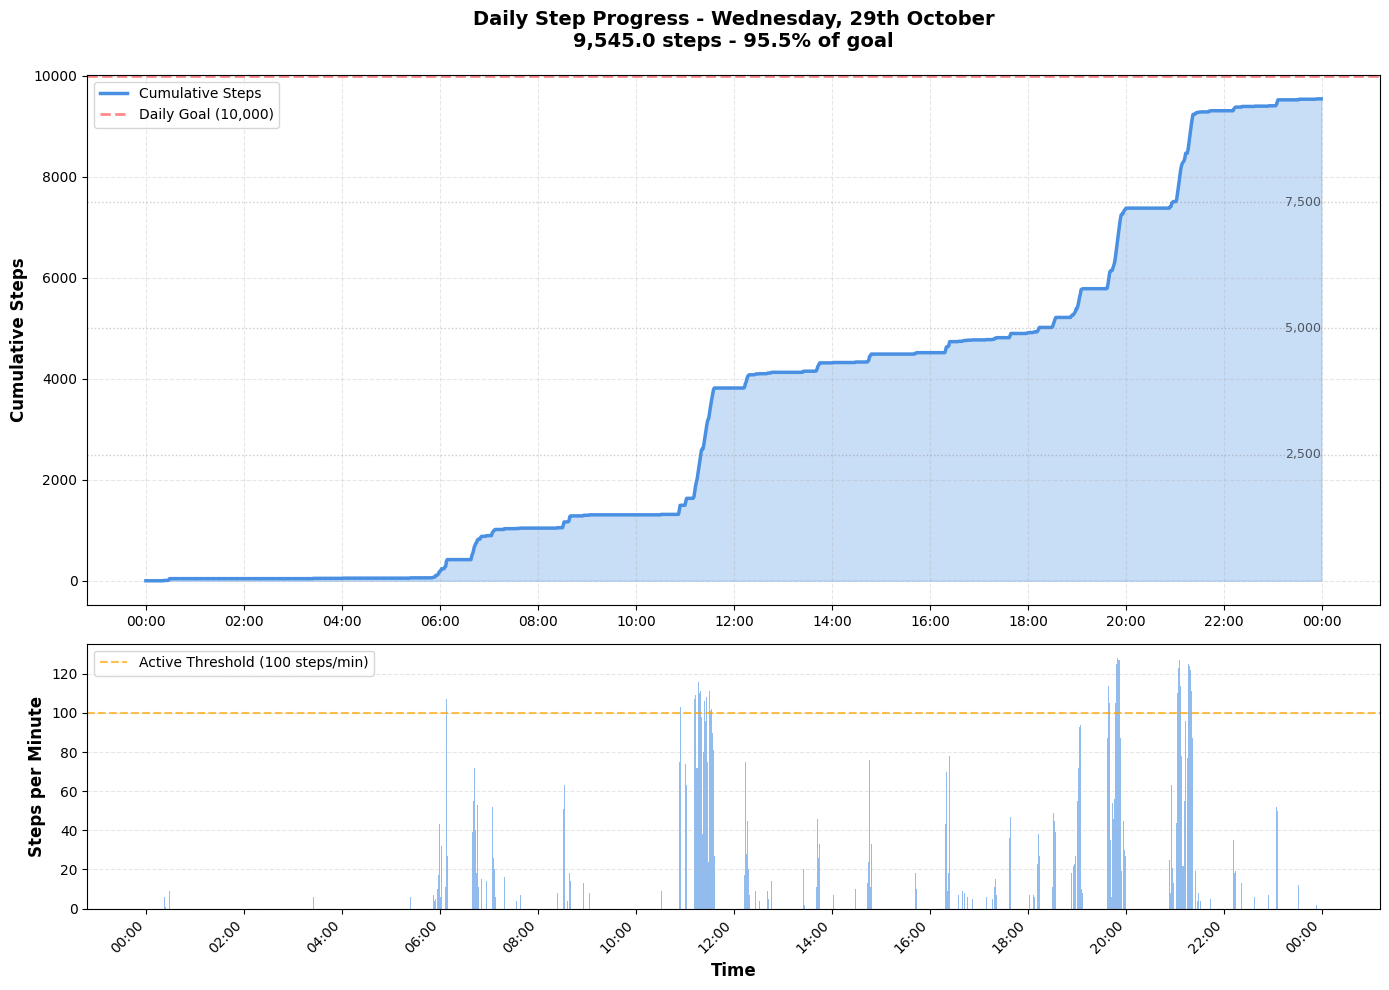

In [94]:
fig2 = plot_step_goals_progress(df_steps_intra, daily_goal=10000)
plt.show()

In [99]:
# ============================================================================
# BONUS: Activity Intensity Heatmap
# ============================================================================

def plot_hourly_activity_heatmap(df_steps_intra, tz='Europe/London'):
    """
    Show hourly activity levels as a heatmap-style bar chart.
    
    Args:
        df_steps_intra: Intraday steps DataFrame
        tz: Timezone for display (default: 'Europe/London')
    
    Returns:
        matplotlib.figure.Figure: The generated figure
    
    Raises:
        ValueError: If input DataFrame is invalid
    """
    # Validate inputs
    validate_dataframe(df_steps_intra, ['time', 'value'], 'Steps DataFrame')
    
    # Convert to local timezone
    df_steps = convert_to_local_tz(df_steps_intra, tz)
    
    # Extract hour from time
    df_steps = df_steps.copy()  # Create copy to avoid modifying cached data
    df_steps['hour'] = df_steps['time'].dt.hour
    
    # Calculate steps per hour using more efficient groupby
    hourly_steps = df_steps.groupby('hour', as_index=False)['value'].sum()
    hourly_steps.columns = ['hour', 'steps']
    
    # Ensure all 24 hours are present
    all_hours = pd.DataFrame({'hour': range(24)})
    hourly_steps = all_hours.merge(hourly_steps, on='hour', how='left').fillna(0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create color map based on activity level
    max_steps = hourly_steps['steps'].max()
    if max_steps > 0:
        colors = plt.cm.YlOrRd(hourly_steps['steps'] / max_steps)
    else:
        colors = ['lightgray'] * 24
    
    # Plot bars
    bars = ax.bar(hourly_steps['hour'], hourly_steps['steps'], 
                  color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    for bar, steps in zip(bars, hourly_steps['steps']):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(steps)}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Steps', fontsize=12, fontweight='bold')
    ax.set_title(f'Hourly Activity Distribution for {formatted_date}', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, linestyle='--', axis='y')
    
    plt.tight_layout()
    return fig

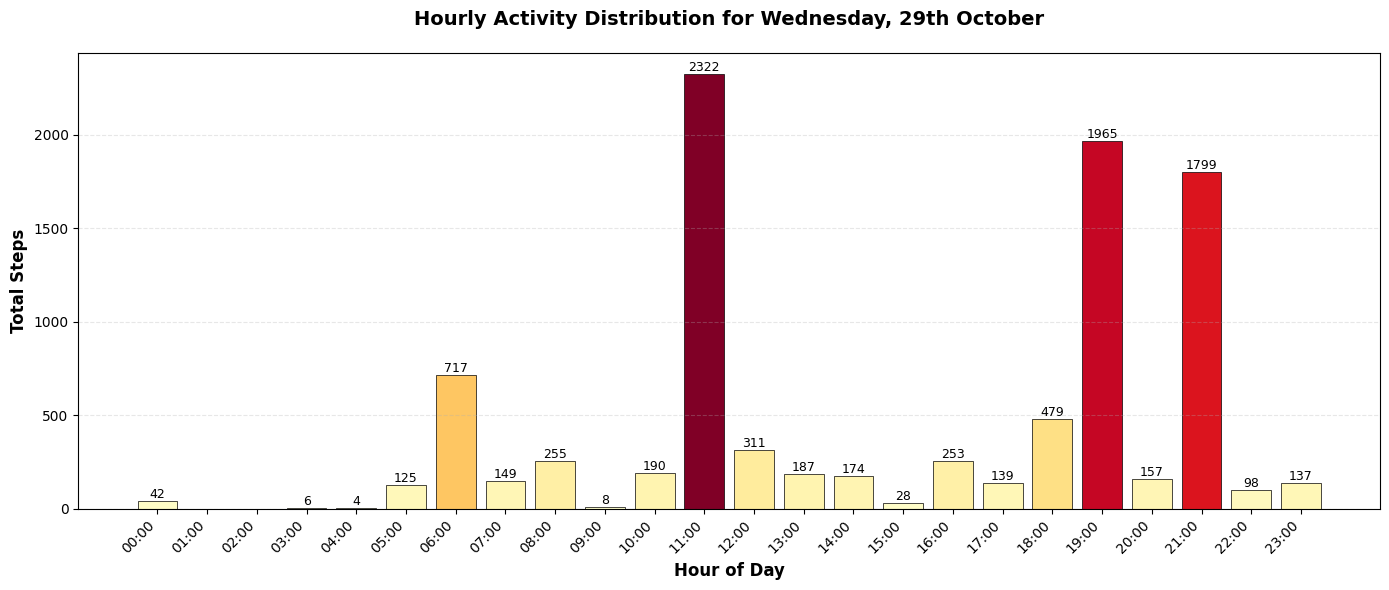

In [100]:
# Bonus: Hourly Activity Heatmap
fig3 = plot_hourly_activity_heatmap(df_steps_intra)
plt.show()